# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [146]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, check_shutter_open, 
    get_each_frame_intensity, get_avg_img, load_data, load_mask,get_fields, reverse_updown, 
    apply_mask, show_img,check_ROI_intensity,run_time, cal_g2, 
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists )

 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask,get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,get_t_iq,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate, plot_saxs_two_g2)

from chxanalys.Two_Time_Correlation_Function import Get_Pixel_Array, auto_two_Array,show_C12, get_one_time_from_two_time

 


%matplotlib notebook

## Make a directory for saving results

In [89]:
CYCLE = '2016_2'

username = getpass.getuser()

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/fluerasu/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [90]:
uid = '77d23e' # CoralPor series 10k frames x 0.01s
uid = 'ad2d24' # Si colloids, bds: 15x15 pre-kin: .05x.08
uid = 'fcdba400-4b7e' # Si colloids, bds: 15x15 pre-kin: .05x.08 faster series (0.005s)
#uid = '012be76c-af98' # Si colloids, bds: 15x15 pre-kin: .05x.08 5k x .01s
#uid = 'ea3b4e1f-1234' # Si colloids, bds: 15x15 pre-kin: .07x.08 10k x .01s
uid = 'b5feeb' #Measurement: Silica 10k fr x .002 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08

# Don't Change these lines below here

In [91]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1846--b5feeb96-cdb0-455f-b078-1b6052326c27--/XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192


In [92]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192_master.h5


In [93]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [94]:
md

{'beam_center_x': 1232.0,
 'beam_center_y': 903.0,
 'count_time': 0.00199,
 'detector_distance': 4.8400002,
 'frame_time': 0.0020000001,
 'framerate': 499.99997625127548,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [95]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']

timeperframe =exposuretime

#center = [  1338, 2167 - 424  ]  # center of the speckle pattern

center = [   1227,1261  ]  # center of the speckle pattern, read from [image_x, image_y], ((not python y,x))

center=[center[1], center[0]]
print (center)



[1261, 1227]


In [96]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)

In [97]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1261, 1227],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'timeperframe': 0.00199,
 'uid': 'b5feeb'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [98]:
mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'fcdba400-4b7e_mask.npy'

<IPython.core.display.Javascript object>


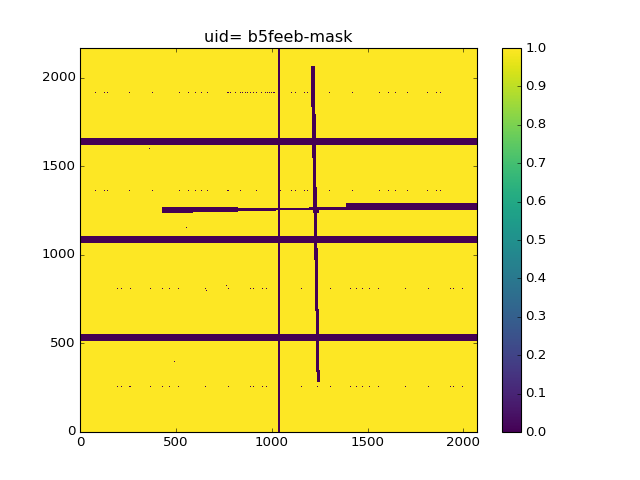

In [100]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [101]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


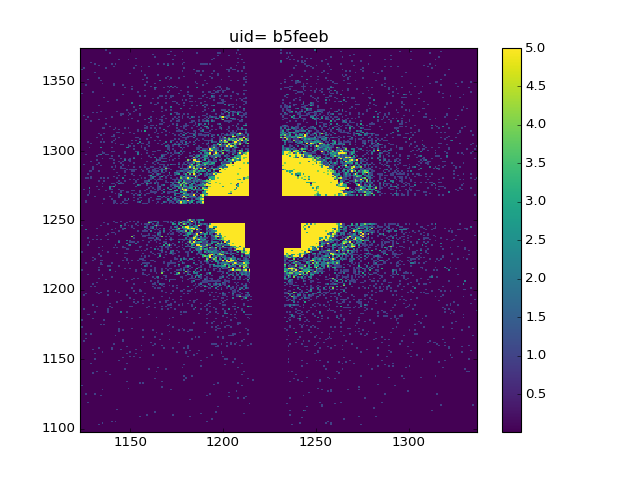

In [102]:
show_img( imgsa[0],  vmin=0.01, vmax=5, logs=False, image_name= 'uid= %s'%uid) 

## Clean Data
* Check shutter open frame to get good time series
* Find bad frames by checking total scattering intensity 


In [103]:
good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,1], plot_ = False )

The first frame with open shutter is : 0


In [104]:
good_series = apply_mask( imgsa[good_start:], mask )

100%|██████████| 10000/10000 [09:59<00:00, 18.57it/s]


<IPython.core.display.Javascript object>


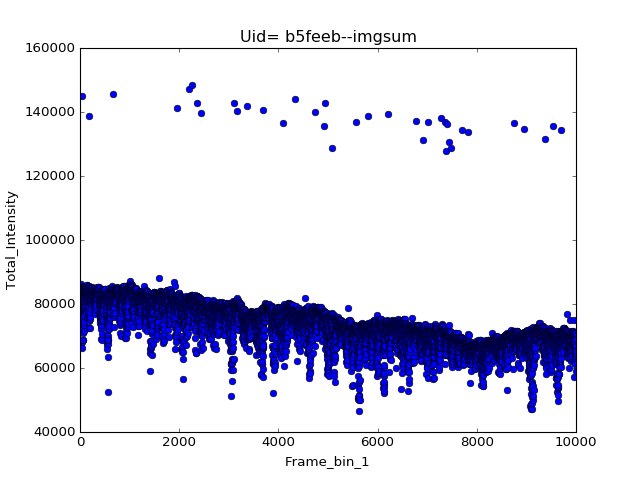

Bad frame list are: [  33  188  672 1954 2202 2260 2359 2431 3103 3168 3358 3699 4096 4327 4734
 4926 4945 5071 5567 5810 6207 6776 6918 7023 7281 7360 7375 7394 7449 7480
 7693 7816 8757 8944 9378 9535 9706]


In [106]:
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 1, 
                                bad_pixel_threshold=1.2e5,  plot_ = True, uid=uid)

## Get intensity average image

<IPython.core.display.Javascript object>


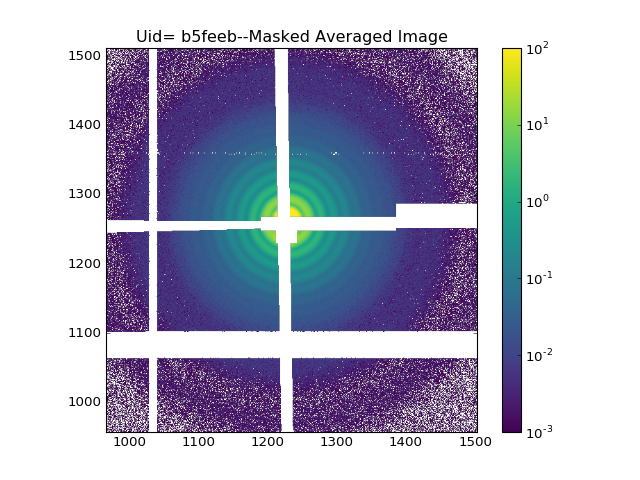

In [107]:
avg_img =  get_avg_img( good_series, sampling = 10, plot_ = True, uid =uid)

## Get circular average 
* Do plot and save q~iq


In [108]:
hmask = create_hot_pixel_mask( avg_img, 1e8)

<IPython.core.display.Javascript object>


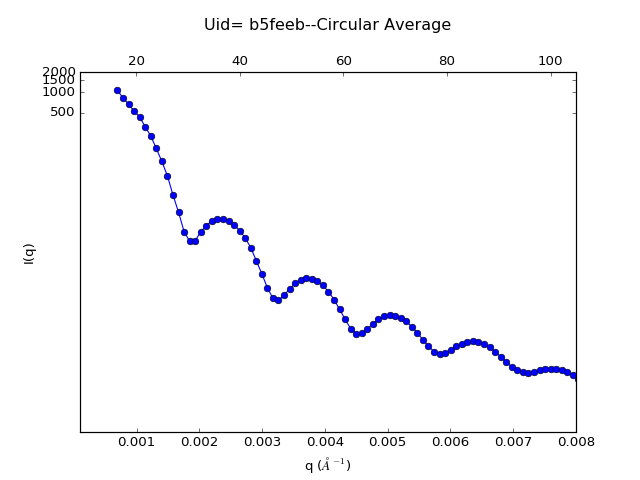

In [114]:
qp, iq, q = get_circular_average( avg_img, mask*hmask, pargs=setup_pargs, 
                    plot_ = True, plot_qinpixel=False, xlim=[0.0001,.008], ylim = [0.01, 2000])

In [115]:
save_lists( [q,iq], ['q','iq'], filename= 'I(q)-uid=%s'%uid, path=data_dir)

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings

In [116]:
inner_radius= 15
outer_radius = 105
width = 6
num_rings = 14


In [117]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs   )

<IPython.core.display.Javascript object>


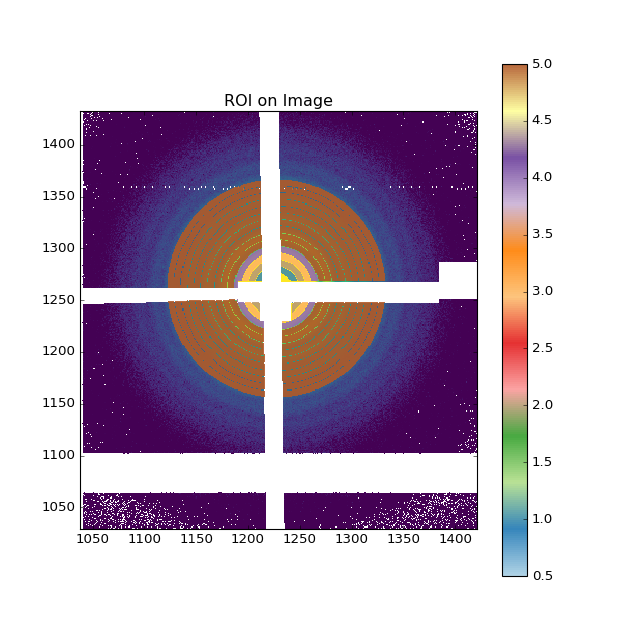

In [118]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=500, alpha=.9)

<IPython.core.display.Javascript object>


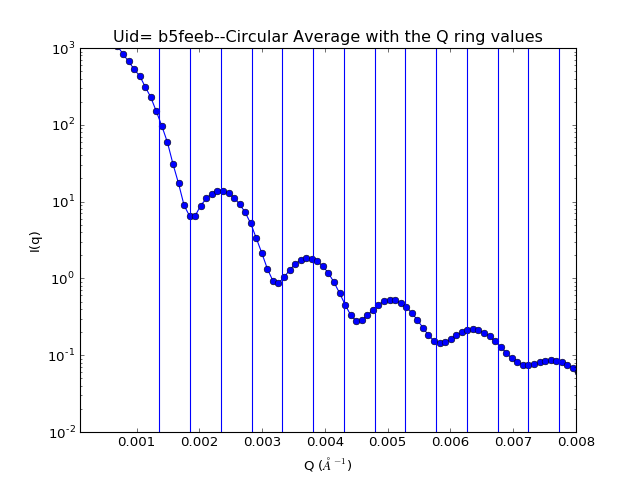

In [119]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.0001,.008], ylim = [0.01, 1000])

## Check one ring intensity

<IPython.core.display.Javascript object>


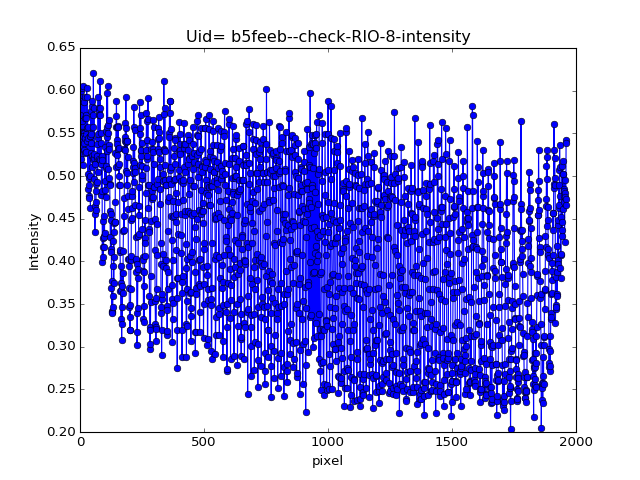

In [120]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 8, uid =uid )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [121]:
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width=10, edges = None )

<IPython.core.display.Javascript object>


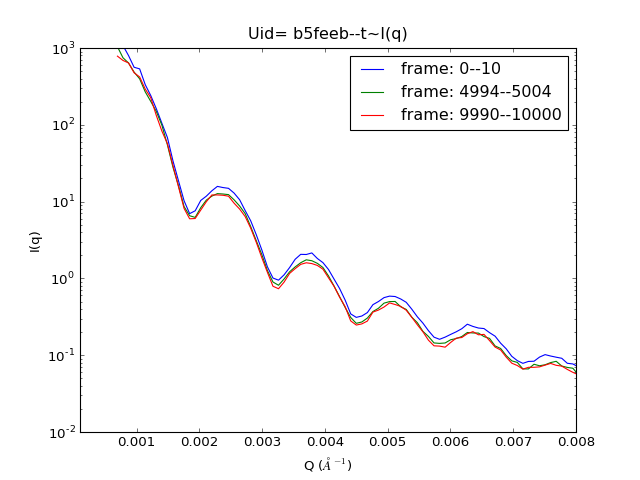

In [122]:
qp, iqs, q = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,   xlim=[0.0001,.008], ylim = [0.01, 1000])

<IPython.core.display.Javascript object>


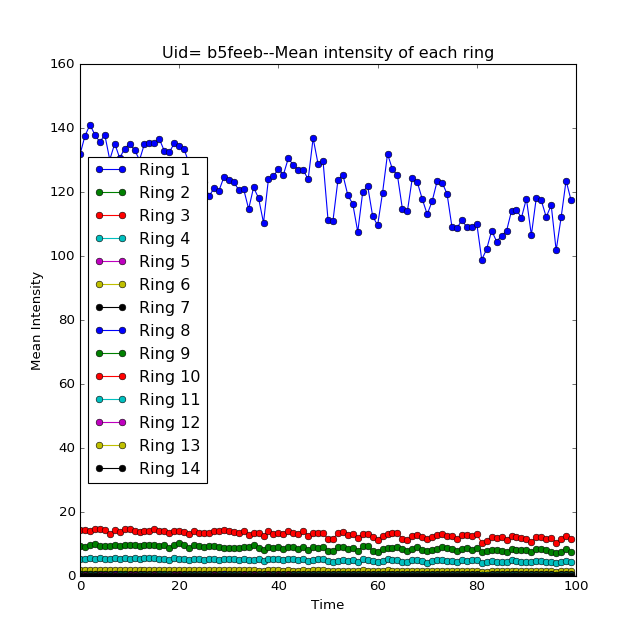

In [123]:
mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = 100,
                                timeperframe = md['frame_time'], plot_ = True, uid = uid  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [124]:
bad_image_process = False
if  len(bad_frame_list):
    bad_image_process = True
bad_image_process 

True

### if define another good_series

In [125]:
if False:
    good_start = 1
    good_end = len( imgs )
    good_series = apply_mask( imgsr[good_start:good_end-1], maskr )

In [126]:
t0 = time.time()
g2, lag_steps  =cal_g2( good_series,  ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

0it [00:00, ?it/s]

In this g2 calculation, the buf and lev number are: 8--12--
10000 frames will be processed...
Bad Frames involved!


10000it [14:19, 12.80it/s]

G2 calculation DONE!
Total time: 14.32 min


In [127]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [128]:
save_saxs_g2(   g2, res_pargs )

The g2 is saved in /XF11ID/analysis/2016_2/fluerasu/Results/ with filename as g2-uid=b5feeb-20160702-1858-.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


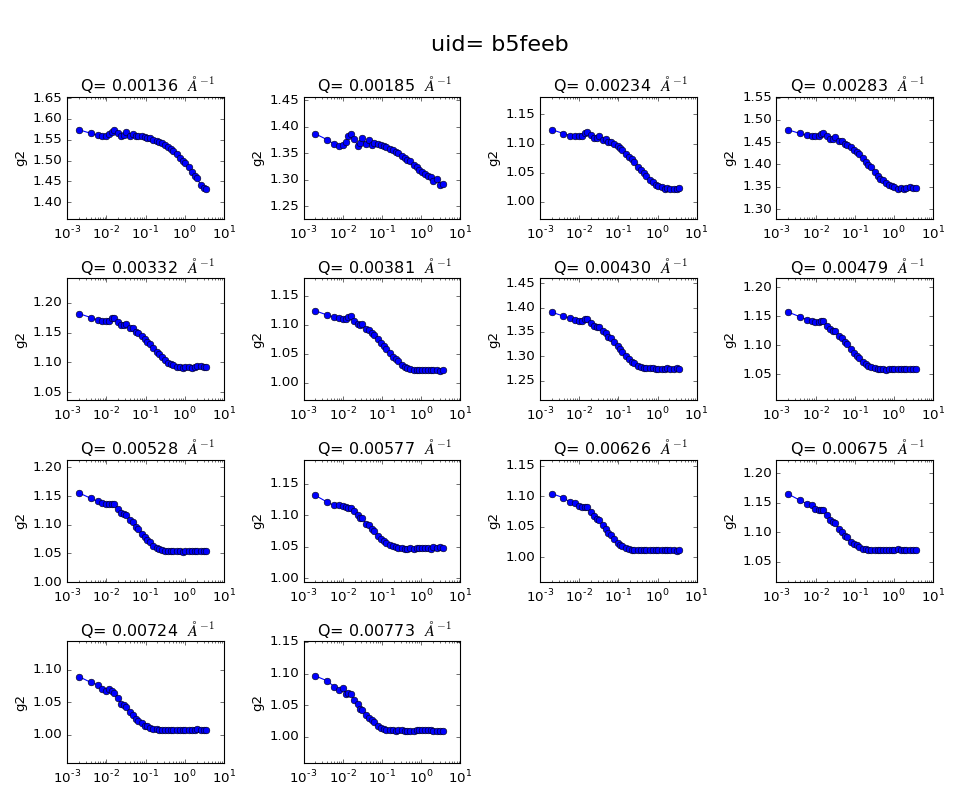

In [129]:
plot_saxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)              
#plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05],qz_center=qz_center, qr_center=qr_center,uid = uid, path=path )

# Fit g2

In [130]:
fit= True

<IPython.core.display.Javascript object>


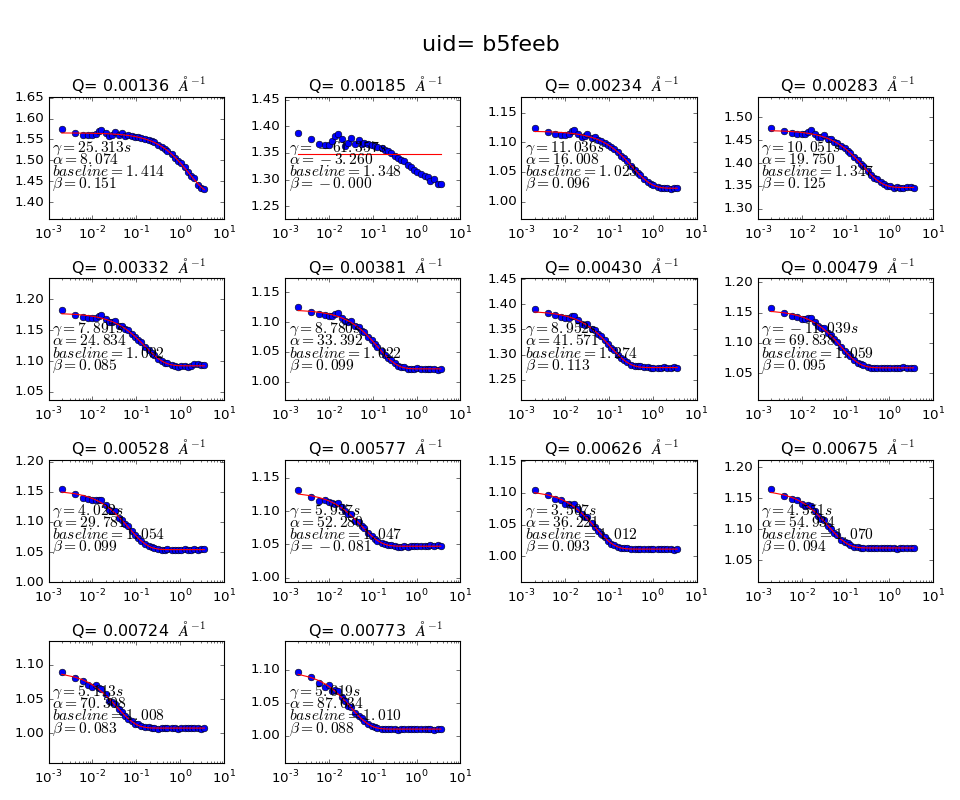

In [131]:
if fit:
    #result = fit_gisaxs_g2( g2, res_pargs, function = 'simple',  vlim=[0.95, 1.05],)
    result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05],)

The fitted diffusion coefficient D0 is:  4.24E-02   A^2S-1


<IPython.core.display.Javascript object>


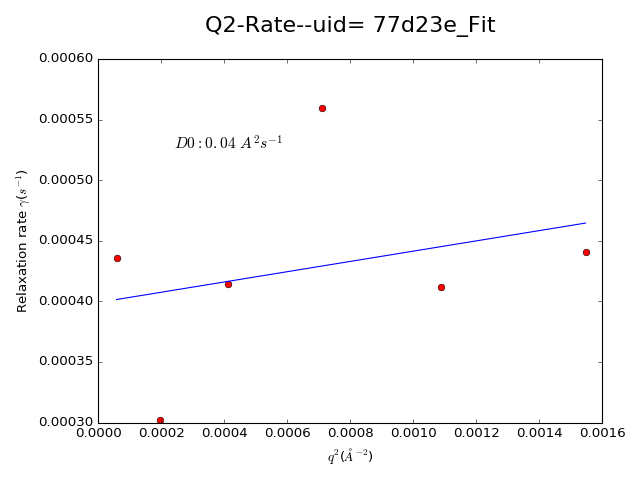

array([ 0.04238705,  0.00039906])

In [51]:
fit_q2_rate(  q_ring_center**2, result['rate'], uid=uid, path= data_dir )

In [132]:
#result

# For two-time

In [133]:
run_two_time = True #False

In [134]:
if run_two_time:    
    qind, pixelist = roi.extract_label_indices(  ring_mask  )
    #good_start = 10
    #good_end = 300 #len( imgs )
    #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
    t0 = time.time()
    data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
    run_time(t0)
    g12b = auto_two_Array( good_series, ring_mask, data_pixel = data_pixel ) 

  0%|          | 0/14 [00:00<?, ?it/s]

Total time: 14.72 min


100%|██████████| 14/14 [01:17<00:00,  6.21s/it]

Total time: 1.29 min


In [137]:
if run_two_time:
    g2b = get_one_time_from_two_time(g12b)
    taus2 = np.arange( g2b.shape[0]) *timeperframe
    res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g2b,  res_pargs2, taus=np.arange( g2b.shape[0]) *timeperframe, filename='g2_from_two-time')

The g2 is saved in /XF11ID/analysis/2016_2/fluerasu/Results/ with filename as g2_from_two-time-uid=b5feeb-20160702-1921-.csv


<IPython.core.display.Javascript object>


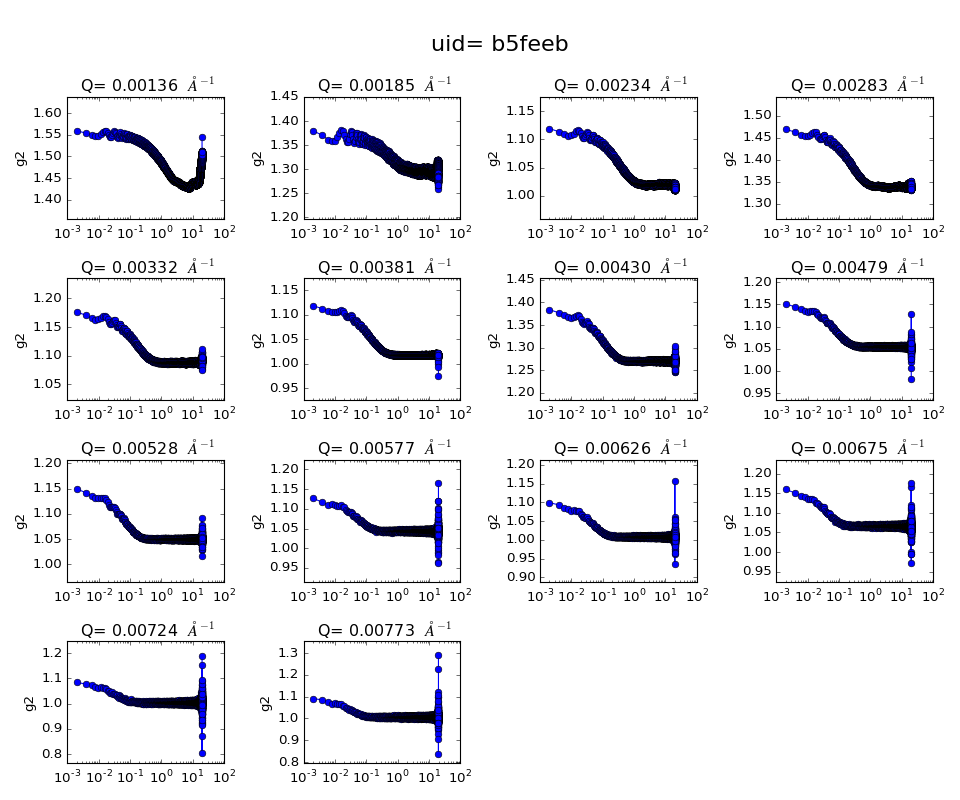

In [138]:
if run_two_time:
    plot_saxs_g2( g2b, taus2,  vlim=[0.95, 1.05], res_pargs=res_pargs2)   

<IPython.core.display.Javascript object>


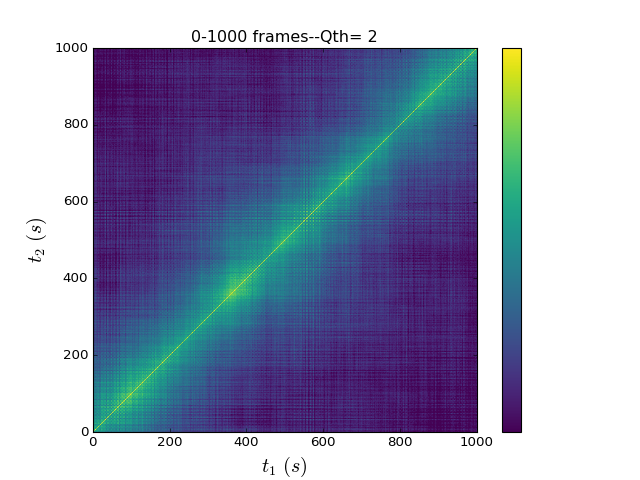

In [152]:
if run_two_time:
    show_C12(g12b, q_ind=2, N1=0, N2=1000, vmin=1.006, vmax=1.2,  )

In [ ]:
#g12b.shape

<IPython.core.display.Javascript object>


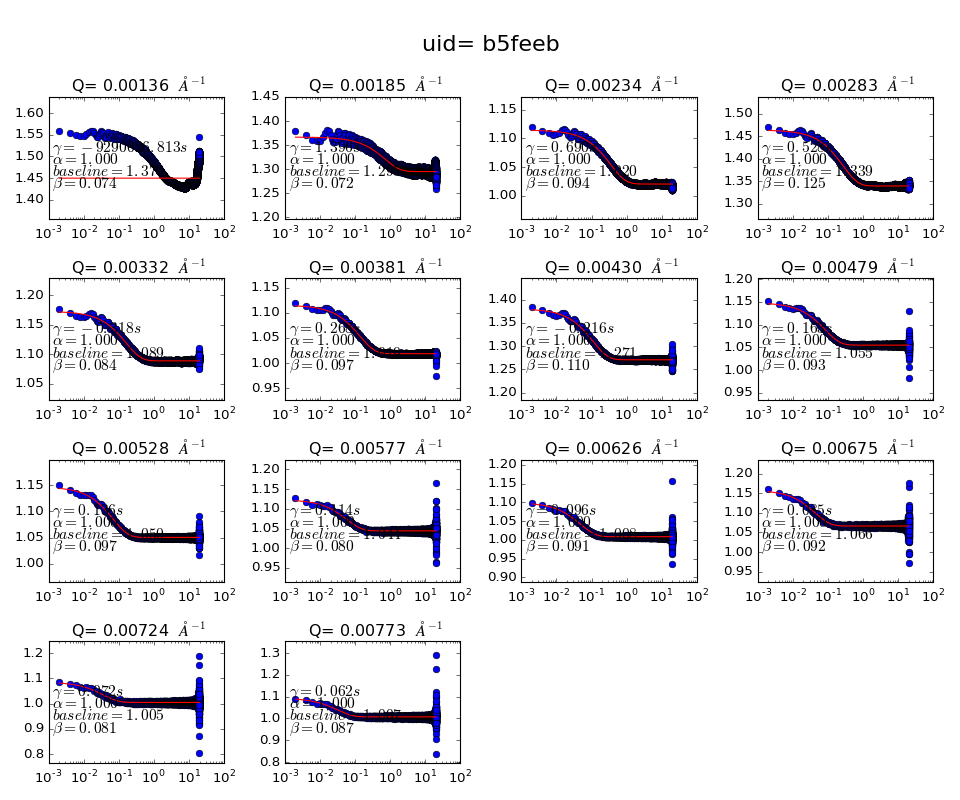

The fitted diffusion coefficient D0 is:  2.99E+05   A^2S-1


<IPython.core.display.Javascript object>


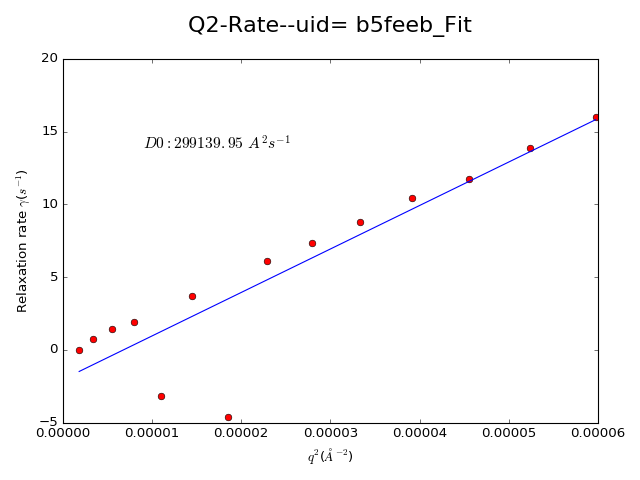

In [141]:
if run_two_time:
    result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])
    fit_q2_rate(  q_ring_center**2, result2['rate'], uid=uid, path= data_dir )
    save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)

<IPython.core.display.Javascript object>


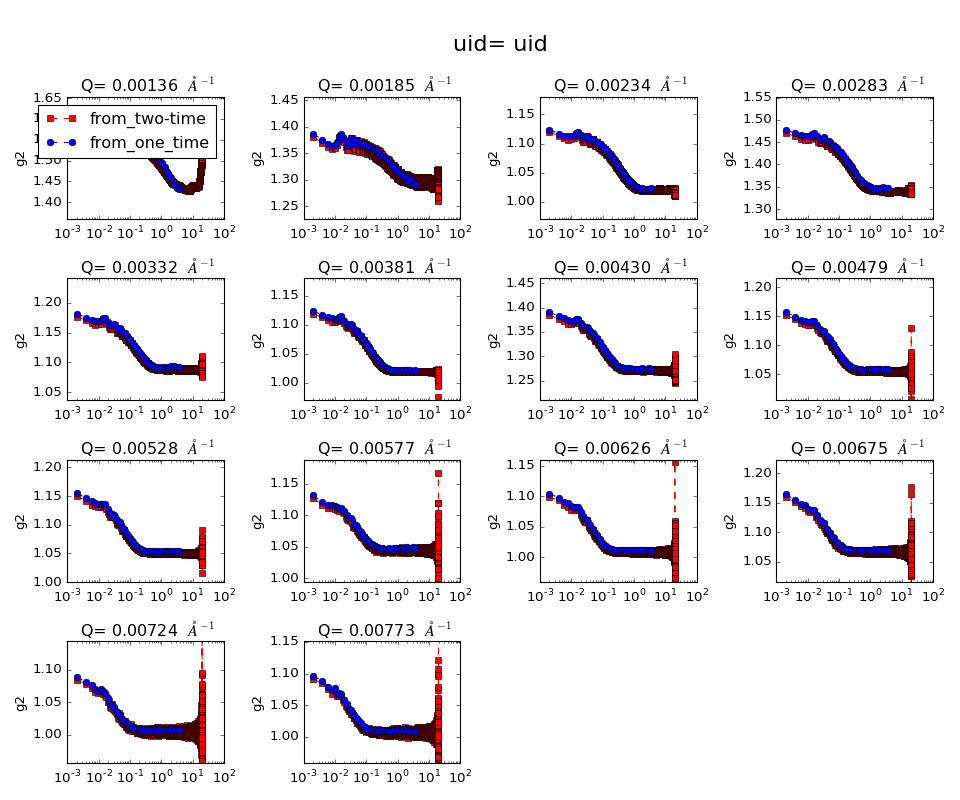

In [149]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 res_pargs=res_pargs, vlim=[.95, 1.05] )

# The End!